In [6]:
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

from scipy.misc import imresize, imsave, fromimage, toimage
from scipy.optimize import fmin_l_bfgs_b
from PIL import Image
from io import BytesIO
from imageio import imread
from skimage.transform import resize
from tqdm import tqdm

import numpy as np
import time
import argparse
import warnings
import sys
import tensorflow as tf
import matplotlib.pyplot as plt
import gc

from keras.models import Model
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, AveragePooling2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input

from keras.utils.data_utils import get_file
from keras.utils.layer_utils import convert_all_kernels_in_model
from keras.backend.tensorflow_backend import set_session

In [2]:
THEANO_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5'
TF_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'

TH_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_th_dim_ordering_th_kernels_notop.h5'
TF_19_WEIGHTS_PATH_NO_TOP = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [8]:
IMG_HEIGHT = 400
IMG_WIDTH = 400
chosen_model = 'vgg16'
# Need to pass image path
base_image_path = 'static\img\img_test.jpg'
style_reference_image_paths = 'static\img\bamboo.jpg'

style_image_paths = [style_reference_image_paths]

content_weight = 0.025
style_weight = 1.0


In [25]:
# dimensions of the generated picture.
def get_ratio(image):
    img = np.asarray(Image.open(image).convert('RGB')).astype('float')
    img_WIDTH = img.shape[0]
    img_HEIGHT = img.shape[1]
    aspect_ratio = float(img_HEIGHT) / img_WIDTH
    return aspect_ratio

aspect_ratio = get_ratio(base_image_path)

def preprocess_image(image_path):
    mode = "RGB"
    img = imread(image_path, pilmode=mode)

    img = resize(img,(IMG_WIDTH, IMG_HEIGHT),anti_aliasing=True)
    
    # Convert the image to a 0-255 scale
    img = 255 * img
    # RGB -> BGR
#     img = img[:, :, ::-1]

#     img[:, :, 0] -= 103.939
#     img[:, :, 1] -= 116.779
#     img[:, :, 2] -= 123.68

    # This function do the same thing above
    img = preprocess_input(img)
    
    if K.image_dim_ordering() == "th":
        img = img.transpose((2, 0, 1)).astype('float32')

    img = np.expand_dims(img, axis=0)
    print(img.shape)
    return img

def deprocess_image(x):
    if K.image_dim_ordering() == "th":
        x = x.reshape((3, IMG_WIDTH, IMG_HEIGHT))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((IMG_WIDTH, IMG_HEIGHT, 3))

    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68

    # BGR -> RGB
    x = x[:, :, ::-1]

    x = np.clip(x, 0, 255).astype('uint8')
    return x

def pooling_func(x):
        if pooltype == 1:
            return AveragePooling2D((2, 2), strides=(2, 2))(x)
        else:
            return MaxPooling2D((2, 2), strides=(2, 2))(x)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

D:\Users\Henry\Anaconda3\envs\keras-gpu\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(1, 400, 400, 3)


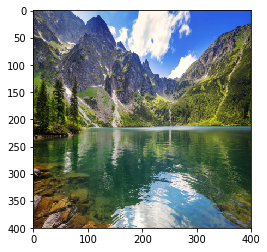

In [26]:
TEST_1 = preprocess_image(base_image_path)
TEST_1 = deprocess_image(TEST_1)
plt.imshow(TEST_1)